# Load Package

In [1]:
#待續
# 紅白酒資料>Ｙ分成01>split>score（recall, precision, AUC）
# 親代個數先設定權重數目的2倍
# 若無改善，試試看multi phase ES 迭代結果子代的10%再從頭開始
#

In [10]:
#https://github.com/YuTaNCCU/201902_ANN_Metaheuristic/tree/master/ES
import random
import pandas as pd
from string import ascii_lowercase
from copy import deepcopy
from abc import ABCMeta, abstractmethod
from copy import deepcopy
from collections import deque
from numpy import argmax
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential 
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
import  seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [16]:
url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/red.csv'
red = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/white.csv'
white = pd.read_csv(url)

red['WineCatg']='red'
white['WineCatg']='white'
Wine_Data = pd.concat([red, white])

display(
    red.shape,
  white.shape,
  Wine_Data.shape,
  Wine_Data.head(5),
  Wine_Data.tail(5)
)

(1599, 13)

(4898, 13)

(6497, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,WineCatg
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,WineCatg
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


In [17]:
print( '原本各種quality記數: \n', Wine_Data.quality.value_counts().sort_index() )
Wine_Data_Y01 = Wine_Data.replace({'quality':[3,4,5,6,7,8,9]},{'quality':[0,0,0,1,1,1,1]})
print( '分類成好壞兩種quality記數: \n', Wine_Data_Y01.quality.value_counts().sort_index() )
Wine_Data_Y01.head(5)

原本各種quality記數: 
 3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64
分類成好壞兩種quality記數: 
 0    2384
1    4113
Name: quality, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,WineCatg
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red


In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X=Wine_Data_Y01.drop(['quality', 'WineCatg'], axis=1)
y=Wine_Data_Y01['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state= 123)

display(
      X_train.shape,
      X_val.shape,
      X_test.shape,
      y_train.shape,
      y_val.shape,
      y_test.shape,
)

(4157, 11)

(1040, 11)

(1300, 11)

(4157,)

(1040,)

(1300,)

# Define ES class

In [19]:
class ES:
    """
    Conducts tabu search
    """
    __metaclass__ = ABCMeta

    #default hyper parameters
    InitialSigma = None
    ParentsSize = None
    ChildSize = None
    tao = None
    
    #for input/output
    KerasModels = None
    WeightsStrucure = None   
    weights = None
    
    #for record
    cur_steps = 1
    best_weight = None
    best_score = None
    
    UseOLSReg=None
    X_train=None
    y_train=None
    
    def __init__(self, KerasModels, X_train, y_train, UseOLSReg=False, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5):
        """
        :param KerasModels: a Keras model, like keras.engine.sequential.Sequential
        :param weights: initial weights, should be a Keras model weight
        :param max_steps: maximum number of steps to run algorithm for
        :param UseOLSReg: If True, than use "OLS Regression" for the last layer
        
        """
        self.KerasModels = KerasModels
        
        self.UseOLSReg = UseOLSReg
        
        self.X_train=X_train
        self.y_train=y_train
 
        if all(isinstance(x, float) for x in [InitialSigma, tao]) and all(x > 0 for x in [InitialSigma, tao]):
            self.InitialSigma = InitialSigma
            self.tao = tao
        else:
            raise TypeError('InitialSigma & tao must be a positive float')
            
        if all(isinstance(x, int) for x in [ParentsSize, ChildSize]) and all(x > 0 for x in [ParentsSize, ChildSize]):
            self.ParentsSize = ParentsSize
            self.ChildSize = ChildSize
        else:
            raise TypeError('ParentsSize, ChildSize & max_steps must be a positive integer')

    def __str__(self): 
        return ('ES STEPS: %d ' +
                'BEST SCORE: %.4f ') % \
               (self.cur_steps, self.best_score)

    def __repr__(self):
        return self.__str__() 
    
    def _FlattenWeights(self, weights):
        """
        flatten weights
        
        param weights: keras神經網路的權重格式:nparray包在list中
        return WeightsStrucure : 神經網路各層的權重shape包在list中，unflatten時會用到
        return FlattenedWeights : 一維list包含所有的權重
        """
        WeightsStrucure = []
        FlattenedWeights = []
        for i_layer in weights:
            WeightsStrucure.append(i_layer.shape)
            if len(i_layer.shape) == 1 :# 該層權重的shape為一維 e.g. (15,)      
                FlattenedWeights.extend(i_layer)
            else :# 該層權重的shape為二維 e.g. (30, 15)  
                for i_links in i_layer:
                    FlattenedWeights.extend(i_links)
        return WeightsStrucure, FlattenedWeights

    def _UnflattenWeights(self, WeightsStrucure, ModifiedWeights):
        """
        Unflatten(回復成原本的結構) weights  
        
        param WeightsStrucure : 神經網路各層的權重shape包在list中
        param ModifiedWeights : 一維list包含所有meteHeuristic修改過的權重
        return: keras神經網路的權重格式:nparray包在list中
        """
        UnflattenWeights = []
        i_index = 0 
        for i_layer in WeightsStrucure:
            if len(i_layer) == 1 : # 該層權重的shape為一維 e.g. (15,)      
                TempList = ModifiedWeights[i_index:(i_index + i_layer[0])]
                TempList = np.asarray(TempList)
                i_index = i_index + i_layer[0]
            else : # 該層權重的shape為二維 e.g. (30, 15)  
                TempList = ModifiedWeights[i_index:(i_index + (i_layer[0]*i_layer[1]))]
                TempList = np.reshape(TempList, i_layer )
                i_index = i_index + (i_layer[0]*i_layer[1])
            UnflattenWeights.append(TempList)
        return UnflattenWeights   
    
    def _best(self, Population_Child_score):
        """
        Finds the best member of a neighborhood
        :param Population_Child_score: a np array
        :return: the indtex of N best member, N = ParentsSize
        """
        return np.array( Population_Child_score ).argsort()[::-1][:self.ParentsSize]
    
    def _Recombination(self, Population_Parents_Weights, Population_Parents_Sigma, rows): #GenerateParents
        """
        Generate New Parents Polulation
        """
        Population_Weights_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        Population_Sigma_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        for index_row, _ in enumerate( Population_Weights_Recombination ):
            """
            可能可以平行計算
            """
            TwoRowschoiced = np.random.choice(Population_Parents_Weights.shape[0], size=2, replace=False,)
            Parent1Mask = np.random.randint(2, size=Population_Parents_Weights.shape[1])
            Parent2Mask = np.full(shape = Population_Parents_Weights.shape[1], fill_value = 1 )  - Parent1Mask
            
            Population_Weights_Recombination[index_row,:] = (Population_Parents_Weights[TwoRowschoiced] * [Parent1Mask, Parent2Mask]).sum(axis=0)
            Population_Sigma_Recombination[index_row,:] = Population_Parents_Sigma[TwoRowschoiced].mean(axis=0)
        return Population_Weights_Recombination, Population_Sigma_Recombination

    def _score(self, ModifiedWeights):
        
        """
        Returns objective function value of a state

        :param state: a state
        :return: objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        self.KerasModels.set_weights(UnflattenedWeights)
        test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train, sample_weight=None) # return ['loss', 'acc']
        return test_on_batch[1]
    #==================
        #==================
          #==================
            #==================
    def _OLSReg(self, ModifiedWeights):
        
        """
        :param : 
        :return: Keras Models, objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        
        #%% OLS Regression
        #obtain the output of an intermediate layer
        #https://keras.io/getting-started/faq/?fbclid=IwAR3Zv35V-vmEy85anudOrlxCExXYwyG6cRL1UR0AaLPU6sZEoBjsbX-8LXQ#how-can-i-obtain-the-output-of-an-intermediate-layer
        self.KerasModels.set_weights(UnflattenedWeights)
        layer_name = 'IntermediateLayer'
        intermediate_layer_model = keras_models_Model(inputs=self.KerasModels.input,
                                         outputs=self.KerasModels.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(self.X_train)

        #fit LM
        lm =  LogisticRegression(random_state=0, solver='liblinear').fit(intermediate_output, self.y_train)
        
        #lm =  LinearRegression().fit(intermediate_output, self.y_train)
        # 印出係數, 截距 print(lm.coef_, lm.intercept_)
        
        #score
        #score = log_loss(y_pred = lm.predict(intermediate_output), y_true= self.y_train)
        
        #get OutLayerWeights
        OutLayerWeights = [np.array(lm.coef_).reshape(self.WeightsStrucure[-2]),
                           np.array(lm.intercept_).reshape(self.WeightsStrucure[-1])]

        #update ES-optimized weights
        UnflattenedWeights[-2:] = OutLayerWeights        
        
        #self.KerasModels.set_weights(UnflattenedWeights)
        #test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train, sample_weight=None) # return ['loss', 'acc']
        
        #print( 'score',score, 'test_on_batch',test_on_batch)
        _, OLS_Optimized_Weight = self._FlattenWeights(UnflattenedWeights)
        return OLS_Optimized_Weight 

    def run(self, weights, max_steps=5, verbose=10, useOLSReg = False):
        """
        Conducts ES
        :param weights: 
        :param max_steps: 
        :param verbose: int which indicates how many iter to show score
        :return: Keras Models, best state and objective function value of best state
        """
        
        if isinstance(weights, list)  :
          
            self.WeightsStrucure, self.weights = self._FlattenWeights(weights)
            self.best_weight = self.weights
            self.best_score = self._score(self.best_weight)
        else:
            raise TypeError('initial_state must be a list') 
            
        self.max_steps = max_steps
        
        #Step1 initial             
        Population_Parents_Weights = np.array([self.weights, self.weights])         
        Population_Parents_Sigma = np.full(shape = (self.ParentsSize, len(self.weights)), fill_value = self.InitialSigma ) 
        Population_Parents_Weights, _ = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ParentsSize )
        self.cur_steps = 1
        while True:   
            #Step2 Child
            ##Discrete Recombination
            Population_Child_Weights, Population_Child_Sigma = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ChildSize )
            ##mutation1
            RamdonNormalValue = np.random.normal(0, 1, 1)
            RamdonNormalValueDifferent = np.random.normal(0, 1, Population_Child_Sigma.shape)
            Population_Child_Sigma = np.exp( (1-self.tao)*RamdonNormalValue + self.tao*RamdonNormalValueDifferent )
            ##mutation2
            Population_Child_Weights = Population_Child_Weights + np.random.normal(0, Population_Child_Sigma, Population_Child_Sigma.shape)
            
            
            # OLS Regression
            if useOLSReg == True:
              for i, i_Child in enumerate(Population_Child_Weights) :
                  OLS_Optimized_Weight = self._OLSReg(i_Child)
                  #print(OLS_Optimized_Weight,'i:\n', i, Population_Child_Weights[i])
                  Population_Child_Weights[i] = OLS_Optimized_Weight
            
            
            #step3 Evaluation
            Population_Child_score = []
            for i_Child in Population_Child_Weights :
                """
                可能可以平行計算
                """
                Population_Child_score.append( self._score(i_Child) )
                 
            BestNIndex = self._best(Population_Child_score)
            Population_Parents_Weights = Population_Child_Weights[BestNIndex,:]
            Population_Parents_Sigma = Population_Child_Sigma[BestNIndex,:]
            
            #更新best
            best_weight_This_Iter =  Population_Child_Weights[BestNIndex,:][0]
            best_score_This_Iter = self._score(Population_Child_Weights[BestNIndex,:][0])
            if best_score_This_Iter > self.best_score:
                self.best_weight =  Population_Child_Weights[BestNIndex,:][0]
                self.best_score = self._score(Population_Child_Weights[BestNIndex,:][0])
        
            #print process 
            if ((self.cur_steps ) % verbose == 0) and verbose:
               print(self)
                
            self.cur_steps = self.cur_steps + 1
            #step4 check stop criteria
            if self.cur_steps > max_steps:
                print( 'Stop: Reach max_steps' )
                break
        return self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = self.best_weight), self.best_score 


# Model Compile

In [37]:
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential, Model as keras_models_Model

K.clear_session() 
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

model = Sequential()
model.add(Dense(round(X_train.shape[1]/2), activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dense(round(X_train.shape[1]/2), activation='relu'))
model.add(Dense(round(X_train.shape[1]/4), activation='relu', name = 'IntermediateLayer'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


# Main

In [50]:
# Initialize
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  model.set_weights(weights)
  model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)
  weights = model.get_weights() 

  # ES
  weights, ES_Optimized_ObjVal  = MyES.run(weights, max_steps=5, verbose = 1)
  
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 5:
      break
      

ES STEPS: 1 BEST SCORE: 0.6618 
ES STEPS: 2 BEST SCORE: 0.6690 
ES STEPS: 3 BEST SCORE: 0.6690 
Stop: Reach max_steps
Epoch 1/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2878 - acc: 0.6688
Epoch 2/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.3581 - acc: 0.6647
Epoch 3/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2747 - acc: 0.6700
Epoch 4/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2747 - acc: 0.6700
Epoch 5/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2747 - acc: 0.6700
Epoch 6/15
4157/4157 [==============================] - 0s 67us/step - loss: 5.2747 - acc: 0.6700
Epoch 7/15
4157/4157 [==============================] - 0s 66us/step - loss: 5.2747 - acc: 0.6700
Epoch 8/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2747 - acc: 0.6700
Epoch 9/15
4157/4157 [==============================] - 0s 64us/step - loss: 5.2747 - acc: 0.6700


# Performance

Our accuracy is 66.84615384615384%


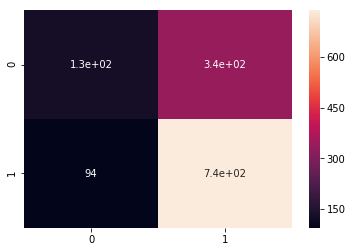

In [65]:
#Confusion Matrix

# Predicting the Test set results
y_score = model.predict(X_test) #X_train X_test
y_pred = (y_score > 0.5)  #y_pred 有 NA

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) #y_train y_test

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1])/sum(sum(cm)))*100))

sns.heatmap(cm,annot=True)
plt.savefig('h.png')

In [88]:
#AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y_test, y_score=y_score)

0.5834668803418803

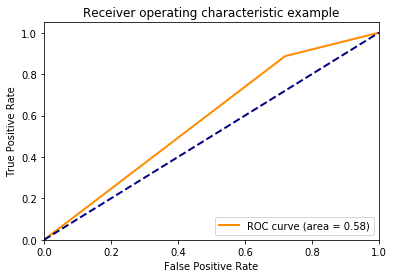

In [86]:
#ROC curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()